# 1. 라이브러리 불러오기

In [16]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns


import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import warnings

from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 분류 SVM
from sklearn.svm import SVC

from collections import Counter

warnings.filterwarnings('ignore')

# # xgboost 패키지 불러오기 
# from xgboost import XGBClassifier

# # 변수 중요도 확인: F1 점수 기준
# from xgboost import plot_importance

# 범주화용 함수선언
def steel_usage(spec):
    if spec is None or (isinstance(spec, float) and math.isnan(spec)):
        return "공통"
    s = str(spec).strip().upper()
    for cat, lst in upper_lists.items():
        if s in lst:
            return cat
    for cat, lst in upper_lists.items():
        if any(token in s for token in lst):
            return cat
    return "공통"

# 2. 데이터 파일 불러오기

In [17]:
df_raw = pd.read_csv(r'C:\Users\이민성\Desktop\포빅아 31기\Scale\SCALE불량.csv', encoding = 'euc-kr')

# 3. 결측치 확인, 이상치 확인 -> 처리

In [18]:
# 1. 결측값 확인
df_raw.info() # 결측값 없음.

# 2. 이상치 확인 및 대체
df_raw.describe() # rolling_temp에 이상치 존재
df_raw[df_raw['rolling_temp'] == 0]

df_raw['temp_for_mean'] = df_raw['rolling_temp'].replace(0, np.nan)
spec_means = df_raw[df_raw['scale'] == '양품'].groupby('spec_long')['temp_for_mean'].mean()
fill_values = df_raw['spec_long'].map(spec_means)
df_raw['rolling_temp'] = df_raw['rolling_temp'].mask(df_raw['rolling_temp'] == 0, fill_values)
df_raw['rolling_temp'] = df_raw['rolling_temp'].fillna(0)
df_raw = df_raw.drop(columns=['temp_for_mean']) # 이상치(rolling_temp = 0 인 경우를, 같은 sepc_long, scale = '양품'인 데이터들의 평균으로 대체'

len(df_raw[df_raw['rolling_temp']==0]) # 대체 확인.

# 3. rolling_date 시(hour) 추출 후 rolling_date 열 제거
df_raw["rolling_hour"] = df_raw["rolling_date"].str.split(":").str[1].astype(int)
df_raw.drop(columns=['rolling_date'], inplace=True)

# 4. plate_no 제거
df_raw.drop(columns=['plate_no'], inplace=True) # 인덱스와 같은 역할이므로 제거

# 5. 연속형 변수들은 단위가 없으므르 단위제거는 생략한다.

# 6. drop 열 결정
df_raw.drop(columns=['spec_country'], inplace=True)      

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  rolling_method   1000 non-null   o

# 파생변수 생성

In [19]:
# 파생변수 생성

# shift_worker
df_raw["shift_worker"] = np.where((df_raw["rolling_hour"] >= 7) 
                                  & (df_raw["rolling_hour"] <= 18),"주간","야간") # rolling_hour을 07 ~ 18 -> 주간 / 19- 06 -> 야간으로 범주화

# fur_pre_time
df_raw["fur_pre_time"] = df_raw["fur_total_time"] - df_raw["fur_soak_time"] - df_raw["fur_heat_time"] # 예열대 시간

# heat_soak_diff
df_raw["heat_soak_diff"] = df_raw["fur_heat_temp"] - df_raw["fur_soak_temp"] # 가열대 균열대 온도차이

# pt_area
df_raw["pt_area"] = df_raw["pt_width"] * df_raw["pt_length"] # plate의 면적

# pt_vol
df_raw["pt_vol"] = df_raw["pt_width"] * df_raw["pt_length"] * df_raw['pt_thick'] # plate의 부피

# steel_usage / 용도로 범주화 진행

hull = ["AB/EH32-TM","NV-E36-TM","BV-EH36-TM","BV-AH36-TL","A131-DH36TM","BV-AH36-TM",
        "NV-A36-TM","GL-D36-TM","NK-KD36-TM","NV-D32-TM","NV-A32-TM","GL-A36-TM","NV-E32-TM",
        "LR-EH32-TM","LR-AH36-TM","GL-A32-TM","NK-KA32-TM","NV-D36-TM","NK-KA","KR-AH32",
        "BV-A","GL-A","NK-KA32","LR-AH36","AB/AH32","GL-A32","LR-AH32","CCS-B","NV-B",
        "NV-A32","BV-AH32","AB/A","NV-A","KR-A","KR-B","LR-A","BV-B","AB/B","LR-B",
        "LR-EH36-TM","BV-AH32-TM","GL-E32-TM","GL-E36-TM","BV-EH32-TM","AB/EH36-TM"]
general = ["JS-SS400","KS-SS400","TOYOTA","VOLKSWAGEN","FORD","MAHINDRA","SKODA","RENAULT",
           "NISSAN","MITSUBISHI","ISUZU"]
offshore = ["API-2W-50T","CHEVROLET","DATSUN","FIAT","FORCE","AMBASSADOR"]
boiler_vessel = ["A516-60","TATA","CHEVROLET","DATSUN","FIAT","FORCE","AMBASSADOR"]
high_strength = ["PILAC-BT33","TATA","CHEVROLET","DATSUN","FIAT","FORCE","AMBASSADOR"]
weld_struct = ["JS-SM490A","JS-SM400A","A283-C","SA283-C","KS-SM490A","KS-SM400A","KS-SM490B","FJS-SM490A",
               "KS-SM400B","JS-SM400B","JS-SM490YB","JS-SM490YA"]
common = ["V42JBN3","COMMON"]
bridge = ["KS-HSB500","A709-36","KS-HSB600"]

upper_lists = {
    "선체구조용": [x.upper() for x in hull],
    "일반구조용": [x.upper() for x in general],
    "해양구조용": [x.upper() for x in offshore],
    "보일러 및 압력용기용": [x.upper() for x in boiler_vessel],
    "고장력강판": [x.upper() for x in high_strength],
    "용접구조용": [x.upper() for x in weld_struct],
    "교량구조용": [x.upper() for x in bridge],
    "공통":       [x.upper() for x in common],
}

df_raw["steel_usage"] = df_raw["spec_long"].apply(steel_usage)

print(df_raw["steel_usage"].value_counts(dropna=False).head())
df_raw.drop(columns=['spec_long'], inplace=True) # spec_long 열 제거

df_raw

steel_usage
선체구조용    703
용접구조용    179
공통        40
고장력강판     40
일반구조용     29
Name: count, dtype: int64


,scale,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,...,rolling_temp,descaling_count,work_group,rolling_hour,shift_worker,fur_pre_time,heat_soak_diff,pt_area,pt_vol,steel_usage
0,양품,T,32,3700,15100,적용,1호기,1열,1144,116,...,934.0,8,1조,7,주간,84,11,55870000,1787840000,선체구조용
1,양품,T,32,3700,15100,적용,1호기,2열,1144,122,...,937.0,8,1조,7,주간,63,9,55870000,1787840000,선체구조용
2,양품,T,33,3600,19200,적용,2호기,1열,1129,116,...,889.0,8,1조,7,주간,87,8,69120000,2280960000,선체구조용
3,양품,T,33,3600,19200,적용,2호기,2열,1152,125,...,885.0,8,1조,7,주간,73,25,69120000,2280960000,선체구조용
4,양품,T,38,3100,13300,적용,3호기,1열,1140,134,...,873.0,8,1조,7,주간,64,12,41230000,1566740000,선체구조용
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,양품,C,19,3400,41500,적용,1호기,2열,1142,55,...,948.0,10,4조,5,야간,62,-9,141100000,2680900000,선체구조용
996,양품,C,19,3400,41500,적용,1호기,2열,1142,55,...,948.0,10,4조,5,야간,68,-9,141100000,2680900000,선체구조용
997,양품,C,17,3400,43700,적용,2호기,2열,1169,65,...,948.0,10,4조,5,야간,85,6,148580000,2525860000,선체구조용
998,양품,C,17,3400,43700,적용,2호기,2열,1169,65,...,948.0,10,4조,6,야간,62,6,148580000,2525860000,선체구조용


# 4. 탐색적 분석  -> 히스토그램, scatter 등 scale 불량과 관계 확인 필수

## **1)가열로별 △temp를 통해 가열로간 차이 파악**

<Axes: xlabel='heat_soak_diff', ylabel='fur_total_time'>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

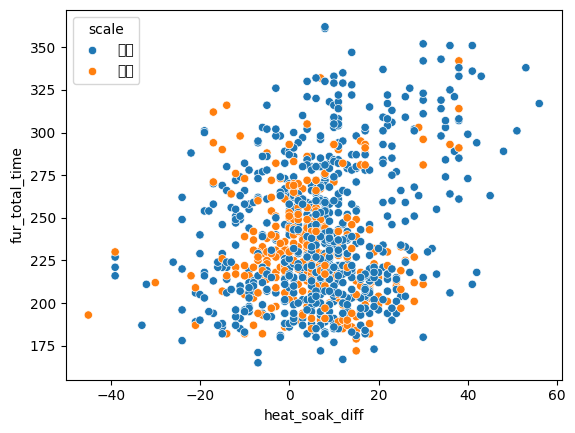

In [20]:
#1
sns.scatterplot(x = 'heat_soak_diff' , y = 'fur_total_time' ,hue = 'scale', color = 'scale', data = df_raw)

### ***해석***
- 가열대 소재온도와 균열대 소재온도 차이에 따른 plate의 scale 여부에 영향을 주는지와 
- 가열로 총 재로시간이 plate의 scale 여부에 영향을 주는지 산점도를 통해 보았다.
- 두 변수만으로는 scale 여부를 분류하기에는 어려워보인다.

## **2) rolling_temp가 1000도일 때 양/불량**

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

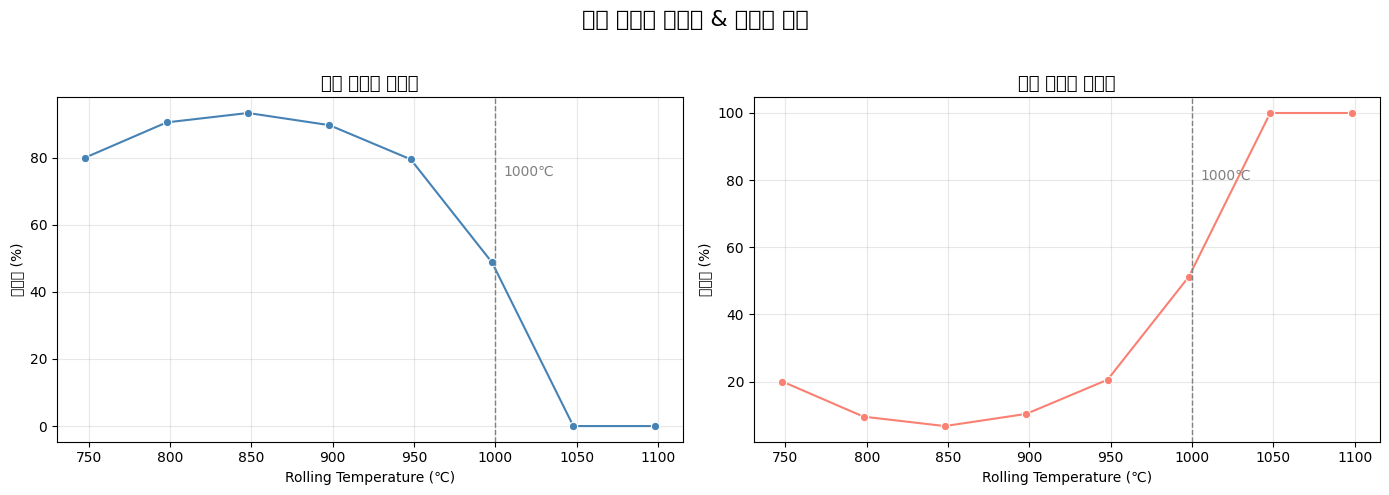

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 0) 기본 검증: 필요한 컬럼 존재/라벨 형태 통일 -----
assert 'rolling_temp' in df_raw.columns, "df_raw에 'rolling_temp' 컬럼이 없습니다."
assert 'scale' in df_raw.columns, "df_raw에 'scale' 컬럼이 없습니다."

# 숫자형(0/1)인 경우 라벨로 변환
if df_raw['scale'].dropna().isin([0,1]).all():
    df_raw = df_raw.copy()
    df_raw['scale'] = df_raw['scale'].map({0:'양품', 1:'불량'})

# ----- 1) 온도 구간 생성 -----
bins = range(int(df_raw['rolling_temp'].min()), int(df_raw['rolling_temp'].max()) + 50, 50)
df_binned = df_raw.copy()
df_binned['temp_bin'] = pd.cut(df_binned['rolling_temp'], bins=bins)

# ----- 2) 구간별 불량률/양품률 계산 (여기서 good_rate/defect_rate를 새로 만듦) -----
defect_rate = (
    df_binned.groupby('temp_bin')['scale']
    .apply(lambda x: (x == '불량').mean() * 100)
    .reset_index(name='불량률')
)
good_rate = (
    df_binned.groupby('temp_bin')['scale']
    .apply(lambda x: (x == '양품').mean() * 100)
    .reset_index(name='양품률')
)

# 구간 중심값 추가 + 정렬
defect_rate['temp_center'] = defect_rate['temp_bin'].apply(lambda x: x.mid)
good_rate['temp_center']   = good_rate['temp_bin'].apply(lambda x: x.mid)
defect_rate = defect_rate.sort_values('temp_center')
good_rate   = good_rate.sort_values('temp_center')

# ----- 3) 플롯 (좌: 양품률, 우: 불량률) -----
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=False)
plt.suptitle('온도 구간별 양품률 & 불량률 비교', fontsize=16)

# 왼쪽: 양품률
sns.lineplot(data=good_rate, x='temp_center', y='양품률',
             marker='o', color='steelblue', ax=axes[0])
axes[0].axvline(1000, color='gray', linestyle='--', lw=1)
axes[0].text(1005, (good_rate['양품률'].max() if good_rate['양품률'].max()>0 else 1)*0.8,
             '1000℃', color='gray')
axes[0].set_title('온도 구간별 양품률', fontsize=13)
axes[0].set_xlabel('Rolling Temperature (℃)')
axes[0].set_ylabel('양품률 (%)')
axes[0].grid(alpha=0.3)

# 오른쪽: 불량률
sns.lineplot(data=defect_rate, x='temp_center', y='불량률',
             marker='o', color='salmon', ax=axes[1])
axes[1].axvline(1000, color='gray', linestyle='--', lw=1)
axes[1].text(1005, (defect_rate['불량률'].max() if defect_rate['불량률'].max()>0 else 1)*0.8,
             '1000℃', color='gray')
axes[1].set_title('온도 구간별 불량률', fontsize=13)
axes[1].set_xlabel('Rolling Temperature (℃)')
axes[1].set_ylabel('불량률 (%)')
axes[1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### ***해석***
- 압연 온도에 따른 불량률을 나타낸 그래프 
- 압연 온도가 950도 이상부터 불량률이 기하급수적으로 상승
- Scale 불량을 최소화하기 위해서는 압연 온도를 950°C 미만, 특히 800~950°C 구간으로 안정적으로 관리하는 것이 중요할 것으로 관측

## **3)HSB 적용 여부에 따른 불량률 비교**

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

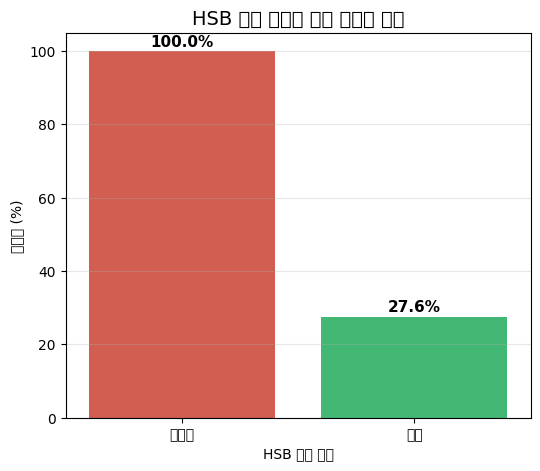

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# HSB 적용별 전체 대비 불량률 계산
hsb_rate = (
    df_raw.groupby('hsb')['scale']
    .apply(lambda x: (x == '불량').mean() * 100)
    .reset_index(name='불량률(%)')
)

# 🎨 색상 팔레트 변경 (적용=초록, 미적용=빨강)
palette = {'적용': '#2ecc71',  # 밝은 그린 (#27ae60 좀 더 진한 그린도 가능)
            '미적용': '#e74c3c'}  # 밝은 레드

plt.figure(figsize=(6,5))
sns.barplot(
    data=hsb_rate,
    x='hsb',
    y='불량률(%)',
    palette=palette
)

# 막대 위에 값 표시
for i, row in hsb_rate.iterrows():
    plt.text(i, row['불량률(%)'] + 0.5,
             f"{row['불량률(%)']:.1f}%",
             ha='center', va='bottom', fontsize=11, fontweight='semibold')

plt.title('HSB 적용 여부에 따른 불량률 비교', fontsize=14)
plt.xlabel('HSB 적용 여부')
plt.ylabel('불량률 (%)')
plt.grid(axis='y', alpha=0.3)
plt.show()


### ***해석***
- **HSB(Hot Scale Breaker) 미적용 시 100% 확률로 불량 발생**<br>
- 다만, **적용 시에도** 여전히 **약 27% 수준의 불량이 남아** 있으므로,
온도 구간, 냉각 속도, 강종별 차이 등 **다른 변수와의 상호작용 분석이 추가로 필요**
- **HSB**는 주로 고온 상태의 슬라브 표면에 발생한 산화 스케일을 제거해 롤 마찰 불균형 및 균열 발생을 방지하는 역할을 수행하므로,<br>
공정 안정성을 위해 **적용 여부가 불량 발생의 주요 결정 요인(Primary Factor) 임을 시사**

### **4) 장입열(1·2열)에 따른 차이 분석**

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

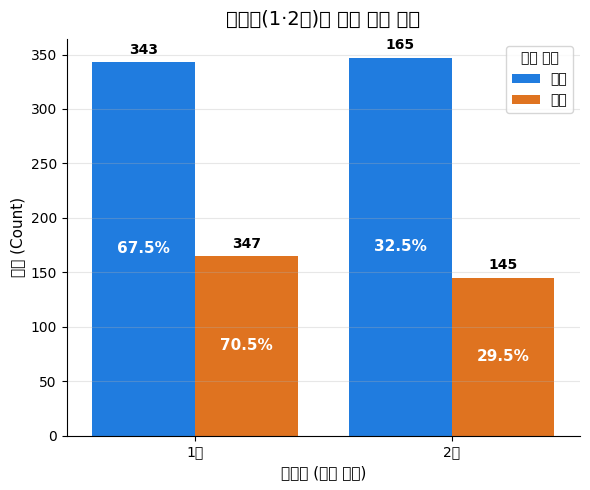

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 집계 (count + 퍼센트)
ct = (
    df_raw.groupby(['fur_input_row','scale'])
    .size()
    .reset_index(name='count')
)
ct['percent'] = ct.groupby('fur_input_row')['count'].transform(lambda s: s/s.sum()*100)

# 2) 순서 지정
order = sorted(ct['fur_input_row'].unique())      # ['1열','2열']
hue_order = ['양품','불량']

# 💡 선명한 원색톤 (파랑, 주황)
colors = ['#007BFF', '#FF6F00']

# 3) 시각화
plt.figure(figsize=(6,5))
ax = sns.barplot(
    data=ct, x='fur_input_row', y='count', hue='scale',
    order=order, hue_order=hue_order,
    palette=colors, linewidth=0  # ✅ 테두리 제거
)

# 4) 라벨: 퍼센트(막대 중앙) + 건수(막대 위)
ct_sorted = (
    ct.set_index(['fur_input_row','scale'])
      .loc[pd.MultiIndex.from_product([order, hue_order])]
      .reset_index()
)

for bar, (_, r) in zip(ax.patches, ct_sorted.iterrows()):
    # 퍼센트 라벨 (막대 중앙)
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f"{r['percent']:.1f}%", ha='center', va='center',
            color='white', fontsize=11, fontweight='bold')
    # 건수 라벨 (막대 위)
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f"{int(r['count'])}", ha='center', va='bottom',
            fontsize=10, fontweight='bold')

# 5) 제목, 축, 스타일
ax.set_title('장입열(1·2열)에 따른 차이 분석', fontsize=14, pad=10)
ax.set_xlabel('장입열 (가열 위치)', fontsize=11)
ax.set_ylabel('건수 (Count)', fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.legend(title='품질 구분', loc='upper right')
sns.despine()
plt.tight_layout()
plt.show()


#### ***해석***
- 장입열(가열 위치) **1열과 2열 모두 불량과 양품의 비율이 거의 동일하게 분포**
- 따라서 **장입열(가열 위치)**은 Scale **불량 발생에 대한 주요 영향 요인으로 보기 어려움**

### **5) 양품 vs 불량 전체 건수 및 비율 비교**

In [25]:
# 1) scale별 개수 및 비율 계산
count_df = (
    df_raw['scale']
    .value_counts(normalize=False)
    .reset_index()
    .rename(columns={'index':'scale', 'scale':'count'})
)
count_df['ratio(%)'] = count_df['count'] / count_df['count'].sum() * 100

# 2) 🎨 색상 세팅 (중간톤 원색)
colors = {
    '양품': '#007BFF',   # 밝은 원색 블루
    '불량': '#E53935'    # 선명한 중간톤 레드
}

# 3) 시각화
plt.figure(figsize=(6,5))
ax = sns.barplot(
    data=count_df,
    x='scale', y='count',
    palette=colors,
    edgecolor=None
)

# 4) 막대 내부에 비율 표시
for i, row in count_df.iterrows():
    ax.text(i, row['count']/2,
            f"{row['ratio(%)']:.1f}%",
            ha='center', va='center',
            color='white', fontsize=12, fontweight='bold')

# 5) 막대 위 건수 표시
for i, row in count_df.iterrows():
    ax.text(i, row['count'] + (count_df['count'].max() * 0.015),
            f"{int(row['count']):,}",
            ha='center', va='bottom',
            fontsize=11, fontweight='semibold')

# 6) 스타일
plt.title('양품 vs 불량 전체 건수 및 비율 비교', fontsize=14, pad=10)
plt.xlabel('품질 구분 (Scale)', fontsize=11)
plt.ylabel('건수 (Count)', fontsize=11)
plt.grid(axis='y', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for /: 'str' and 'str'

#### ***해석***
- 전체 데이터 중 **양품이 69%, 불량이 31%로 약 7:3 비율**의 분포
- 이는 분류 모델에서 **클래스 불균형이 심각한 수준(예: 9:1 이상)은 아니**므로,<br>
분석 시 SMOTE와 같은 **오버샘플링 미적용**
- 다만, **불량률이 30% 수준으로 현실적인 생산 라인의 결함 비율과 유사**하다는 점에서<br>
본 데이터는 실제 공정 상황을 충분히 반영한 학습 데이터로서 신뢰도 확보 가능
- 따라서 기본 **모델 학습 시에는 원본 데이터의 Scale 비율을 유지**하고,<br>
이후 **모델별 성능(Recall, Precision) 편차가 클 경우에만 SMOTE 적용** 여부를 실험적 비교 대상으로 고려하기로 결정

# 5. 모델링

## 1.로지스틱 회귀

Optimization terminated successfully.
         Current function value: 0.398194
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      694
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Nov 2025   Pseudo R-squ.:                  0.3556
Time:                        01:15:31   Log-Likelihood:                -278.74
converged:                       True   LL-Null:                       -432.57
Covariance Type:            nonrobust   LLR p-value:                 2.254e-64
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.3349      0.126    -10.606      0.000      -1.582      -1.088
fur_soak_temp 

,Variable,VIF
0,const,1.00
5,pt_vol,1.04
2,fur_heat_time,1.17
3,rolling_temp,1.71
4,descaling_count,1.77
1,fur_soak_temp,2.84


Train 예측/분류 결과
Accuracy: 0.826

Confusion Matrix: 
[[439  45]
 [ 77 139]] 

              precision    recall  f1-score   support

           0      0.851     0.907     0.878       484
           1      0.755     0.644     0.695       216

    accuracy                          0.826       700
   macro avg      0.803     0.775     0.786       700
weighted avg      0.821     0.826     0.822       700

Test 예측/분류 결과
Accuracy: 0.800

Confusion Matrix: 
[[189  17]
 [ 43  51]] 

              precision    recall  f1-score   support

           0      0.815     0.917     0.863       206
           1      0.750     0.543     0.630        94

    accuracy                          0.800       300
   macro avg      0.782     0.730     0.746       300
weighted avg      0.794     0.800     0.790       300



<Axes: >

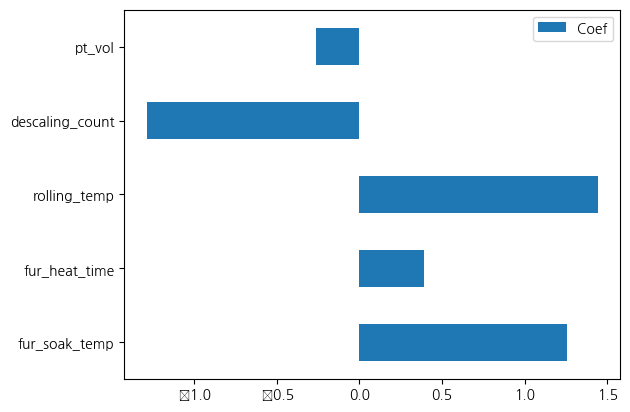

In [43]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_LG = df_raw.copy()
# 2. 설명변수 scale 0과 1로 변환
df_model_LG['scale'] = df_model_LG['scale'].map({'양품': 0, '불량': 1})
# 3. 목표변수, 설명변수 분리 (더미화 이전에 수행)
df_raw_y_LG = df_model_LG["scale"]
df_raw_x_LG = df_model_LG.drop("scale", axis = 1)
df_raw_y_LG = pd.DataFrame(df_raw_y_LG, columns=['scale'])
# 4. 범주형 변수 dummy화 (설명변수 X에만 적용)
df_raw_x_LG_dummy = pd.get_dummies(df_raw_x_LG, drop_first = True)
v_feature_names = df_raw_x_LG_dummy.columns
# 5. train / test 분리 (더미화된 X 사용)
df_train_x_LG, df_test_x_LG, df_train_y_LG, df_test_y_LG = train_test_split(df_raw_x_LG_dummy, df_raw_y_LG,
                                                 test_size = 0.3, random_state = 1234)
# 6. 설명변수 X scaling 변환
scaler = StandardScaler()
scaler.fit(df_train_x_LG)

x_train_scaled_arr = scaler.transform(df_train_x_LG)
x_test_scaled_arr = scaler.transform(df_test_x_LG)

x_train_scaled = pd.DataFrame(x_train_scaled_arr, columns=v_feature_names, index=df_train_x_LG.index)
x_test_scaled = pd.DataFrame(x_test_scaled_arr, columns=v_feature_names, index=df_test_x_LG.index)

df_train_LG = df_train_y_LG.join(x_train_scaled)
df_test_LG = df_test_y_LG.join(x_test_scaled)
# 7. 로지스틱 회귀 모델에 변수들을 넣고 실행. 결과를 계속 확인하면서 후진제거법으로 유의하지않은 변수들부터 제거.
log_model = smf.logit(formula = " scale ~ fur_soak_temp + fur_heat_time + rolling_temp + descaling_count + pt_vol " ,data = df_train_LG)

log_result = log_model.fit()
print(log_result.summary())
# 다중공선성 확인
df_train_x = df_train_LG[['fur_soak_temp' , 'fur_heat_time' , 'rolling_temp' , 'descaling_count' , 'pt_vol']]
df_train_x_const = add_constant(df_train_x) 
df_vif = pd.DataFrame()
df_vif["Variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) \
                 for i in range(df_train_x_const.shape[1])]

# VIF 정렬
display(df_vif.sort_values("VIF", ascending = True).round(2))
# train 데이터 예측
y_pred_train = log_result.predict(df_train_LG)
# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)


# test 데이터 예측
y_pred_test = log_result.predict(df_test_LG)
# 0과 1의 값을 가진 class로 변환
y_pred_test_class = (y_pred_test > 0.5).astype(int)
# 실제 train 데이터와 예측 결과 비교
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train_LG["scale"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train_LG["scale"],y_pred_train_class)),"\n")
print(classification_report(df_train_LG["scale"], y_pred_train_class, digits=3))

# 실제 train 데이터와 예측 결과 비교
print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test_LG["scale"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_LG["scale"],y_pred_test_class)),"\n")
print(classification_report(df_test_LG["scale"], y_pred_test_class, digits=3))
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({'Coef': log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y='Coef')

## 2. Decision Tree

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Accuracy on training set: 1.000
Accuracy on test set: 0.990
Score on training set: 0.989
Score on test set: 0.993


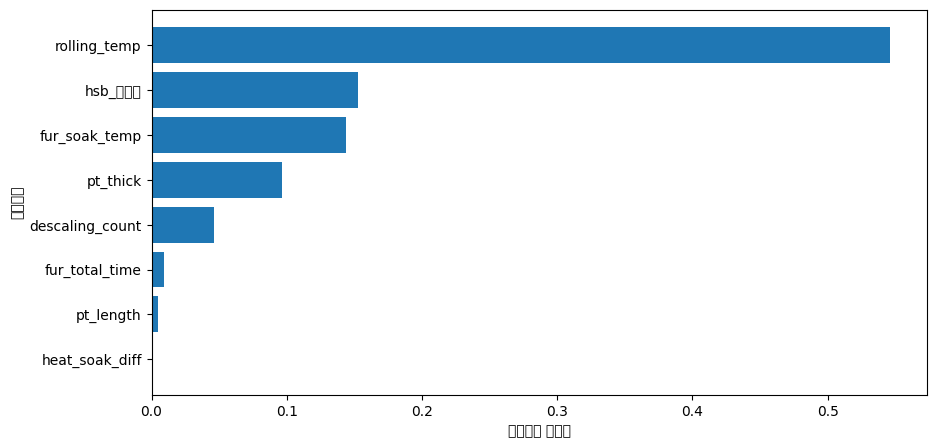

Test Accuracy: 0.993

Test Confusion matrix: 
[[206   0]
 [  2  92]]
              precision    recall  f1-score   support

           0      0.990     1.000     0.995       206
           1      1.000     0.979     0.989        94

    accuracy                          0.993       300
   macro avg      0.995     0.989     0.992       300
weighted avg      0.993     0.993     0.993       300



In [14]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_DT = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거 // 근데 전처리 다했으면 이게 없는게 정상
# df_model_DT.drop(['혹시 더 필요하면 여기서 제거'], axis=1, inplace=True)

# 3. 목표변수, 설명변수 분리 (더미화 이전에 수행)
df_raw_y_DT = df_model_DT["scale"]
df_raw_x_DT = df_model_DT.drop("scale", axis = 1)
df_raw_y_DT = df_raw_y_DT.map({'불량': 1, '양품': 0})

# 4. 범주형 변수 dummy화 (설명변수 X에만 적용)
df_raw_x_DT_dummy = pd.get_dummies(df_raw_x_DT)

# 5. train / test 분리 (더미화된 X 사용)
df_train_x_DT, df_test_x_DT, df_train_y_DT, df_test_y_DT = train_test_split(df_raw_x_DT_dummy, df_raw_y_DT, test_size = 0.3, random_state = 1234)

# 6. HyperParameter 조작 전 기본모델 성능확인

tree_uncust = DecisionTreeClassifier(random_state=1234 )
tree_uncust.fit(df_train_x_DT, df_train_y_DT)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x_DT, df_train_y_DT)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x_DT, df_test_y_DT)))


# 7. Grid_Search를 통한 최적의 hyperparameter 찾기 

# dt_model = DecisionTreeClassifier(random_state=1234)

# #parameter값들을 제한하여 최적의 파라미터를 찾아냄.
# param_grid = {
#     "max_depth": list(range(1, 21)),         
#     "min_samples_split": list(range(20, 60,5)), 
#     "min_samples_leaf": list(range(10, 21,3))  
# }

# grid_dt = GridSearchCV(dt_model, 
#                        param_grid, 
#                        scoring="roc_auc", 
#                        cv=5,            
#                        n_jobs=-1)

# grid_dt.fit(df_train_x_DT, df_train_y_DT)

# print("best estimator model: \n{}".format(grid_dt.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_dt.best_params_))

# print(f"\nbest score ({grid_dt.scoring}): \n{grid_dt.best_score_:.3f}")

# grid-search한 결과, 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 35 로 확인된다.
 
# 8. 최종모델의 성능확인
tree_final = DecisionTreeClassifier(min_samples_leaf = 6, min_samples_split = 35,\
                                   max_depth = 13, random_state=1234, )
tree_final.fit(df_train_x_DT, df_train_y_DT)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x_DT, df_train_y_DT)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x_DT, df_test_y_DT)))

# 9. 상위 20개의 중요설명 변수들 시각화하여서 확인.

# 변수명
v_feature_names = df_train_x_DT.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

df_plot = df_importance[df_importance["Importance"] > 0]
df_plot = df_plot.sort_values("Importance", ascending=True)
coordinates = range(len(df_plot))
plt.figure(figsize=(10, 5))
plt.barh(y=coordinates, width=df_plot["Importance"])
plt.yticks(coordinates, df_plot["Feature"])

plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")


plt.show()

# 10. Confusion Matrix

y_pred = tree_final.predict(df_test_x_DT)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x_DT, df_test_y_DT)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y_DT, y_pred)))
print(classification_report(df_test_y_DT, y_pred, digits=3))


# 별첨. Decision Tree 시각화코드
# 앞서 결정한 파라미터값들을 대입하여 Decision Tree를 시각화하였음.
# tree_final = DecisionTreeClassifier(max_depth=11, min_samples_split=37, min_samples_leaf=13, random_state=1234)
# tree_final.fit(df_train_x_DT, df_train_y_DT)

# v_feature_name = df_train_x_DT.columns
# export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
#                 feature_names = v_feature_name, impurity = True, filled = True)

# with open("tree_final.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

## 3.Random Forest

Accuracy on training set: 1.000
Accuracy on test set: 0.967
Score on training set: 0.939
Score on test set: 0.913


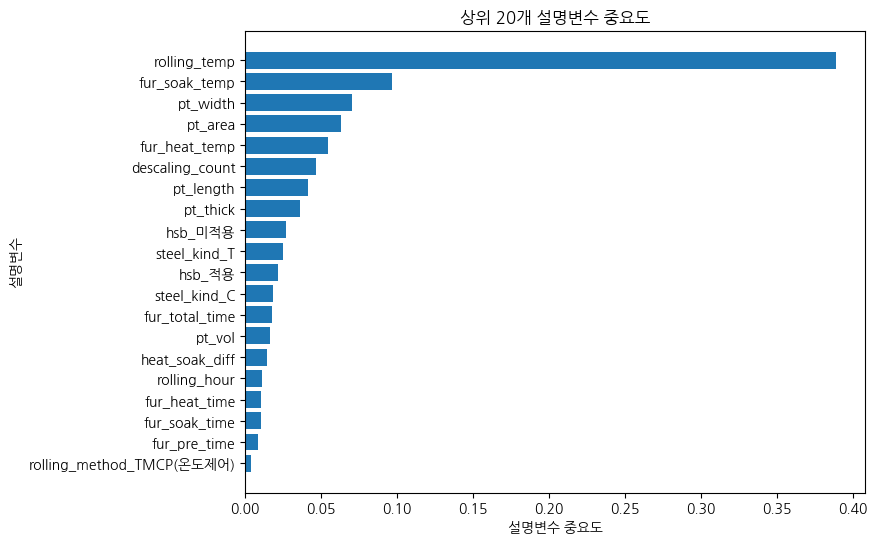

Test Accuracy: 0.913

Test Confusion matrix: 
[[206   0]
 [ 26  68]]
              precision    recall  f1-score   support

           0      0.888     1.000     0.941       206
           1      1.000     0.723     0.840        94

    accuracy                          0.913       300
   macro avg      0.944     0.862     0.890       300
weighted avg      0.923     0.913     0.909       300



In [ ]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_RF = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거 // 근데 전처리 다했으면 이게 없는게 정상
# df_model_RF.drop(['혹시 더 필요하면 여기서 제거'], axis=1, inplace=True)

# 3. 목표변수, 설명변수 분리 (더미화 이전에 수행)
df_raw_y_RF = df_model_RF["scale"]
df_raw_x_RF = df_model_RF.drop("scale", axis = 1)

# 4. 범주형 변수 dummy화 (설명변수 X에만 적용)
df_raw_x_RF_dummy = pd.get_dummies(df_raw_x_RF)
df_raw_y_RF = df_raw_y_RF.map({'불량': 1, '양품': 0})

# 5. train / test 분리 (더미화된 X 사용)
df_train_x_RF, df_test_x_RF, df_train_y_RF, df_test_y_RF = train_test_split(df_raw_x_RF_dummy, df_raw_y_RF, test_size = 0.3, random_state = 1234)
# 5. HyperParameter 조작 전 기본모델 성능확인

tree_uncust = RandomForestClassifier(random_state=1234 )
tree_uncust.fit(df_train_x_RF, df_train_y_RF)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x_RF, df_train_y_RF)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x_RF, df_test_y_RF)))


# # 6. Grid_Search를 통한 최적의 hyperparameter 찾기 // 범위 수정하고 진행

# rf_model = RandomForestClassifier(random_state=1234)

# #parameter값들을 제한하여 최적의 파라미터를 찾아냄.
# param_grid = {
#     "max_depth": list(range(5, 15,2)),         
#     "min_samples_split": list(range(20, 41,4)), 
#     "min_samples_leaf": list(range(10, 21,3)),
#     "n_estimators": list(range(100, 500, 100))
# }

# grid_rf = GridSearchCV(rf_model, 
#                        param_grid, 
#                        scoring="roc_auc", 
#                        cv=3,            
#                        n_jobs=-1)

# grid_rf.fit(df_train_x_RF, df_train_y_RF)

# print("best estimator model: \n{}".format(grid_rf.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_rf.best_params_))

# print(f"\nbest score ({grid_rf.scoring}): \n{grid_rf.best_score_:.3f}")

# grid-search한 결과, 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 20, n_estimators = 100 로 확인된다.
 
# 7. 최종모델의 성능확인
tree_final = RandomForestClassifier(max_depth=11, min_samples_leaf=10,
                                   min_samples_split=20, n_estimators = 100, random_state=1234 )
tree_final.fit(df_train_x_RF, df_train_y_RF)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x_RF, df_train_y_RF)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x_RF, df_test_y_RF)))

# 8. 상위 20개의 중요설명 변수들 시각화하여서 확인.

# 변수명
v_feature_names = df_train_x_RF.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

top20 = df_importance.sort_values("Importance", ascending=False).head(20)

# 시각화
plt.figure(figsize=(8,6))
plt.barh(y = range(len(top20)), width = top20["Importance"])
plt.yticks(range(len(top20)), top20["Feature"])
plt.gca().invert_yaxis()  # 중요도 높은 게 위로 오도록 뒤집기
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")
plt.title("상위 20개 설명변수 중요도")
plt.show()


plt.show()

# 9. Confusion Matrix

y_pred = tree_final.predict(df_test_x_RF)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x_RF, df_test_y_RF)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y_RF, y_pred)))
print(classification_report(df_test_y_RF, y_pred, digits=3))


# 별첨. Decision Tree 시각화코드
# 앞서 결정한 파라미터값들을 대입하여 Decision Tree를 시각화하였음.
# tree_final = DecisionTreeClassifier(max_depth=11, min_samples_split=37, min_samples_leaf=13, random_state=1234)
# tree_final.fit(df_train_x_RF, df_train_y_RF)

# v_feature_name = df_train_x_RF.columns
# export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
#                 feature_names = v_feature_name, impurity = True, filled = True)

# with open("tree_final.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

## Gradient Boosting

Accuracy on training set: 1.000
Accuracy on test set: 0.993
Score on training set: 1.000
Score on test set: 0.990


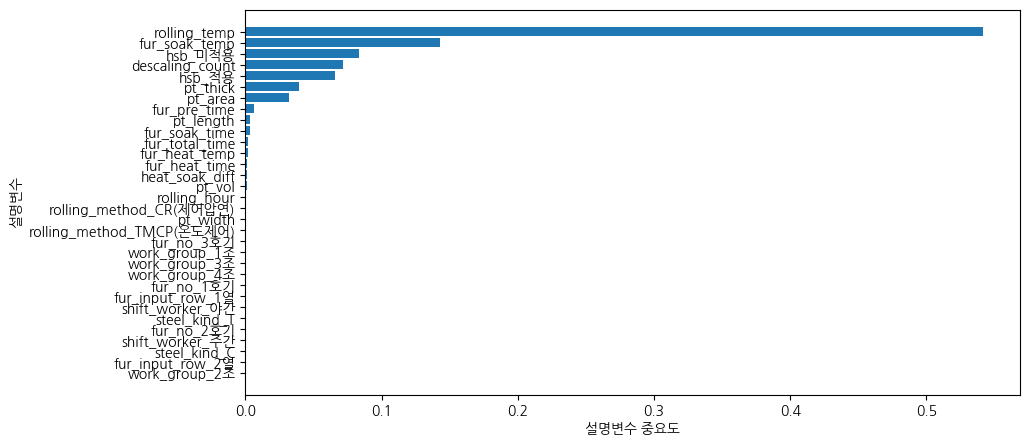

Test Accuracy: 0.990

Test Confusion matrix: 
[[ 92   2]
 [  1 205]]
              precision    recall  f1-score   support

          불량      0.989     0.979     0.984        94
          양품      0.990     0.995     0.993       206

    accuracy                          0.990       300
   macro avg      0.990     0.987     0.988       300
weighted avg      0.990     0.990     0.990       300



In [15]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_GB = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거 // 근데 전처리 다했으면 이게 없는게 정상
# df_model_GB.drop(['혹시 더 필요하면 여기서 제거'], axis=1, inplace=True)
# 3. 목표변수, 설명변수 분리 (더미화 이전에 수행)
df_raw_y_GB = df_model_GB["scale"]
df_raw_x_GB = df_model_GB.drop("scale", axis = 1)

# 4. 범주형 변수 dummy화 (설명변수 X에만 적용)
df_raw_x_GB_dummy = pd.get_dummies(df_raw_x_GB)

# 5. train / test 분리 (더미화된 X 사용)
df_train_x_GB, df_test_x_GB, df_train_y_GB, df_test_y_GB = train_test_split(df_raw_x_GB_dummy, df_raw_y_GB, test_size = 0.3, random_state = 1234)
# 5. HyperParameter 조작 전 기본모델 성능확인

tree_uncust = GradientBoostingClassifier(random_state=1234 )
tree_uncust.fit(df_train_x_GB, df_train_y_GB)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x_GB, df_train_y_GB)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x_GB, df_test_y_GB)))


# 6. Grid_Search를 통한 최적의 hyperparameter 찾기 // 범위 수정하고 진행

# gb_model = GradientBoostingClassifier(random_state=1234)

# #parameter값들을 제한하여 최적의 파라미터를 찾아냄.
# param_grid = {
#     "max_depth": list(range(5, 11)),         
#     "min_samples_split": list(range(15, 31, 2)), 
#     "min_samples_leaf": list(range(10, 16,2)),
#     "n_estimators": [100,300,50],
#     "learning_rate": [0.1, 0.4,0.1]
# }

# grid_gb = GridSearchCV(gb_model, 
#                        param_grid, 
#                        scoring="roc_auc", 
#                        cv=3,            
#                        n_jobs=-1)

# grid_gb.fit(df_train_x_GB, df_train_y_GB)

# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))

# print(f"\nbest score ({grid_gb.scoring}): \n{grid_gb.best_score_:.3f}")

# grid-search한 결과, 'max_depth': 10, 'min_samples_leaf': 10, 
#'min_samples_split': 21, 'n_estimator': 300, ''learning_rate': 0.1 로 확인된다.
 
# 7. 최종모델의 성능확인
tree_final = GradientBoostingClassifier(min_samples_leaf = 10, min_samples_split = 21,\
                                   max_depth = 10, random_state=1234, learning_rate = 0.1, n_estimators = 300)
tree_final.fit(df_train_x_GB, df_train_y_GB)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x_GB, df_train_y_GB)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x_GB, df_test_y_GB)))

# 8. 상위 20개의 중요설명 변수들 시각화하여서 확인.

# 변수명
v_feature_names = df_train_x_GB.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

df_plot = df_importance[df_importance["Importance"] > 0]
df_plot = df_plot.sort_values("Importance", ascending=True)
coordinates = range(len(df_plot))
plt.figure(figsize=(10, 5))
plt.barh(y=coordinates, width=df_plot["Importance"])
plt.yticks(coordinates, df_plot["Feature"])

plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")


plt.show()

# 9. Confusion Matrix

y_pred = tree_final.predict(df_test_x_GB)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x_GB, df_test_y_GB)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y_GB, y_pred)))
print(classification_report(df_test_y_GB, y_pred, digits=3))


# 별첨. Decision Tree 시각화코드
# 앞서 결정한 파라미터값들을 대입하여 Gradient Boosting를 시각화하였음.
# tree_final = GradientBoostingClassifier(max_depth=11, min_samples_split=37, min_samples_leaf=13, random_state=1234)
# tree_final.fit(df_train_x_GB, df_train_y_GB)

# v_feature_name = df_train_x_GB.columns
# export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
#                 feature_names = v_feature_name, impurity = True, filled = True)

# with open("tree_final.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

## XGBoosting

Accuracy on training set: 1.000
Accuracy on test set: 0.997
Score on training set: 1.000
Score on test set: 0.997


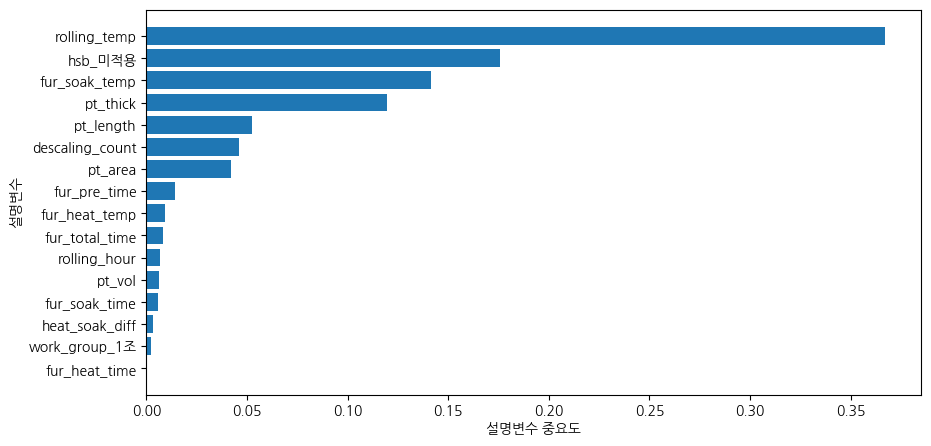

Test Accuracy: 0.997

Test Confusion matrix: 
[[206   0]
 [  1  93]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           1      1.000     0.989     0.995        94

    accuracy                          0.997       300
   macro avg      0.998     0.995     0.996       300
weighted avg      0.997     0.997     0.997       300



In [17]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_XG = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거 // 근데 전처리 다했으면 이게 없는게 정상
# df_model_DT.drop(['혹시 더 필요하면 여기서 제거'], axis=1, inplace=True)
df_model_XG['scale'] = df_model_XG['scale'].map({'양품': 0, '불량': 1})
# 3. 목표변수, 설명변수 분리 (더미화 이전에 수행)
df_raw_y_XG = df_model_XG["scale"]
df_raw_x_XG = df_model_XG.drop("scale", axis = 1)

# 4. 범주형 변수 dummy화 (설명변수 X에만 적용)
df_raw_x_XG_dummy = pd.get_dummies(df_raw_x_XG)

# 5. train / test 분리 (더미화된 X 사용)
df_train_x_XG, df_test_x_XG, df_train_y_XG, df_test_y_XG = train_test_split(df_raw_x_XG_dummy, df_raw_y_XG, test_size = 0.3, random_state = 1234)
# 5. HyperParameter 조작 전 기본모델 성능확인

tree_uncust = XGBClassifier(random_state=1234 )
tree_uncust.fit(df_train_x_XG, df_train_y_XG)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x_XG, df_train_y_XG)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x_XG, df_test_y_XG)))

# # 6. Grid_Search를 통한 최적의 hyperparameter 찾기 // 범위 수정하고 진행

# xg_model = XGBClassifier(random_state=1234)

# #parameter값들을 제한하여 최적의 파라미터를 찾아냄.
# param_grid = {
#     "max_depth": list(range(1, 21)),         
#     "n_estimators": [100,300,50],
#     "learning_rate": [0.1,0.5,0.1] 
# }

# grid_xg = GridSearchCV(xg_model, 
#                        param_grid, 
#                        scoring="roc_auc", 
#                        cv=3,            
#                        n_jobs=-1)

# grid_xg.fit(df_train_x_XG, df_train_y_XG)

# print("best estimator model: \n{}".format(grid_xg.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_xg.best_params_))

# print(f"\nbest score ({grid_xg.scoring}): \n{grid_xg.best_score_:.3f}")

# # grid-search한 결과, 'max_depth': 6, 'n_estimators' : 50, 'learning_rate' : 0.1 로 확인된다.
 
# 7. 최종모델의 성능확인
tree_final = XGBClassifier(max_depth = 6, learning_rate = 0.1, n_estimators = 50, random_state=1234)
tree_final.fit(df_train_x_XG, df_train_y_XG)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x_XG, df_train_y_XG)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x_XG, df_test_y_XG)))

# 8. 상위 20개의 중요설명 변수들 시각화하여서 확인.

# 변수명
v_feature_names = df_train_x_XG.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

df_plot = df_importance[df_importance["Importance"] > 0]
df_plot = df_plot.sort_values("Importance", ascending=True)
coordinates = range(len(df_plot))
plt.figure(figsize=(10, 5))
plt.barh(y=coordinates, width=df_plot["Importance"])
plt.yticks(coordinates, df_plot["Feature"])

plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")


plt.show()

# 9. Confusion Matrix

y_pred = tree_final.predict(df_test_x_XG)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x_XG, df_test_y_XG)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y_XG, y_pred)))
print(classification_report(df_test_y_XG, y_pred, digits=3))



# 별첨. Decision Tree 시각화코드
# 앞서 결정한 파라미터값들을 대입하여 Decision Tree를 시각화하였음.
# tree_final = DecisionTreeClassifier(max_depth=11, min_samples_split=37, min_samples_leaf=13, random_state=1234)
# tree_final.fit(df_train_x_DT, df_train_y_DT)

# v_feature_name = df_train_x_DT.columns
# export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
#                 feature_names = v_feature_name, impurity = True, filled = True)

# with open("tree_final.dot") as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

## XGBoosting_Early_Stop

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# # sklearn XGBoost 모델의 조기 중단:fit( )에 파라미터 입력(early_stopping_rounds, eval_metrics, eval_set.)
# # 모델 파라미터 지정:n_estimators, learning_rate, max_depth 등 지정
# # 조기 중간 파라미터 지정: early_stopping_rounds 
# # 평가지표 지정:logloss

# # 모델 성능 평가 데이터
# eval_set = [(df_test_x_XG, df_test_y_XG)]

# # 2. 조기 중단 기능이 포함된 XGBClassifier 모델 정의
# # n_estimators를 300~1000 사이의 큰 값으로 설정합니다.
# xgb_stop = XGBClassifier(
#     n_estimators=500,  # 넉넉하게 설정 (어차피 최적 지점에서 멈춤)
#     learning_rate=0.1, 
#     max_depth=6,       # (GridSearch에서 찾은 값이나 기본값 사용)
#     random_state=1234
# )

# # 3. 모델 학습 (조기 중단 파라미터 적용)
# print("--- XGBoost 조기 중단 학습 시작 ---")
# xgb_stop.fit(
#     df_train_x_XG, 
#     df_train_y_XG,
    
#     # --- 조기 중단 파라미터 ---
#     # 150 라운드(트리) 동안 성능 향상이 없으면 학습 중단
#     early_stopping_rounds=150, 
    
#     # 평가 지표: logloss (이진 분류에 표준적으로 사용됨)
#     eval_metric="logloss", 
    
#     # 검증 세트: 매 라운드마다 이 데이터로 성능을 평가
#     eval_set=eval_set, 
    
#     # True로 설정하면 학습 과정을 보여줍니다. (150번 동안 향상 없으면 멈춤)
#     verbose=True 
# )
# print("--- XGBoost 조기 중단 학습 완료 ---")


# # 4. 최적 모델 정보 확인 (학습이 멈춘 지점)
# print(f"\n최적 n_estimators (트리 개수): {xgb_stop.best_iteration}")
# print(f"최적 성능 (LogLoss): {xgb_stop.best_score:.4f}")

# # 5. 최적 모델로 Test 데이터 예측 및 평가
# # (best_iteration 시점의 모델로 자동 예측됨)
# xgb_pred_stop = xgb_stop.predict(df_test_x_XG)

# print('\n--- 조기 중단 최종 모델 평가 (Test) ---')
# # print('\n (사용자 정의 함수 eval_class_model 결과) \n')
# # eval_class_model(df_test_y_XG, xgb_pred_stop) # 이 함수가 정의되어 있어야 함

# print('\n (Classification Report) \n')
# print(classification_report(df_test_y_XG, xgb_pred_stop, digits=3))

## SVM

In [19]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_SVM = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거 // 근데 전처리 다했으면 이게 없는게 정상
# df_model_SVM.drop(['혹시 더 필요하면 여기서 제거'], axis=1, inplace=True)

# 3. 목표변수, 설명변수 분리 (더미화 이전에 수행)
df_raw_y_SVM = df_model_SVM["scale"]
df_raw_x_SVM = df_model_SVM.drop("scale", axis = 1)

df_raw_y_SVM = df_raw_y_SVM.map({'불량': 1, '양품': 0})

# 4. 범주형 변수 dummy화 (설명변수 X에만 적용)
df_raw_x_SVM_dummy = pd.get_dummies(df_raw_x_SVM)

# 5. train / test 분리 (더미화된 X 사용)
df_train_x_SVM, df_test_x_SVM, df_train_y_SVM, df_test_y_SVM = train_test_split(df_raw_x_SVM_dummy, df_raw_y_SVM, test_size = 0.3, random_state = 1234)

# 6. 정규화 실시

#StandardScaler 객체 생성
scaler = StandardScaler()
scaler.fit(df_train_x_SVM)

# (이후 모든 모델에는 이 _scaled 데이터를 사용해야 함)
df_train_x_SVM_scaled = scaler.transform(df_train_x_SVM)
df_test_x_SVM_scaled = scaler.transform(df_test_x_SVM)

# 7. 기본 모델 생성(hyperparameter 설정 X)
svm_uncust = SVC(random_state=1234)
svm_uncust.fit(df_train_x_SVM_scaled, df_train_y_SVM)

# train 모델 정확도
print("Train Accuracy : {:.3f}".format(svm_uncust.score(df_train_x_SVM_scaled, df_train_y_SVM)))
# test 모델 정확도
print("Test Accuracy : {:.3f}".format(svm_uncust.score(df_test_x_SVM_scaled, df_test_y_SVM)))

# # 8. grid search를 통해 hyperparameter 최적화

# # SVM에서 탐색할 하이퍼파라미터 범위 설정
# # 교수님께서 언급하신내용은 예제에서의 cost는 너무 작은 수준이라고 하셨다.
# # 그렇기에 조언해주신대로 범위를 설정하여 grid search를 진행하고,
# # 결과값을 보고 범위를 수정하는 것이 바람직하다고 생각한다.

# para_c = [10 **c for c in range(-2, 5)] 

# para_gamma = [10 **gamma for gamma in range(-3, 5)]

# # 기본 모델
# estimator = SVC(random_state=1234)

# # 구하고자 하는 parameter와 범위
# param_grid = {"C": para_c,
#               "gamma": para_gamma}

# # 3-fold cross-validation을 사용하여 정확도가 높은 최적 parameter 찾기
# # (cv=3으로 설정, 필요시 5 등으로 조절)
# grid_svc = GridSearchCV(estimator, param_grid, scoring="roc_auc", n_jobs = -1)


# grid_svc.fit(df_train_x_SVM_scaled, df_train_y_SVM)

# # 결과 출력
# print("--- 7. Grid Search 결과 ---")
# print("\nbest parameter: \n{}".format(grid_svc.best_params_))
# print("\nbest score (Train set CV): {:.3f}".format(grid_svc.best_score_))

#search grid 결과, {'C': 10, 'gamma': 0.1} 로 나왔다.
 
# 9. 최종모델의 성능확인
svc_final = SVC(gamma=0.1, C=10, random_state=1234)
svc_final.fit(df_train_x_SVM_scaled, df_train_y_SVM)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(svc_final.score(df_train_x_SVM_scaled, df_train_y_SVM)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(svc_final.score(df_test_x_SVM_scaled, df_test_y_SVM)))


# 10. Confusion Matrix

y_pred = svc_final.predict(df_test_x_SVM_scaled)
print("Test Accuracy: {0:.3f}\n".format(svc_final.score(df_test_x_SVM_scaled, df_test_y_SVM)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y_SVM, y_pred)))
print(classification_report(df_test_y_SVM, y_pred, digits=3))



Train Accuracy : 0.923
Test Accuracy : 0.900
Score on training set: 0.999
Score on test set: 0.877
Test Accuracy: 0.877

Test Confusion matrix: 
[[192  14]
 [ 23  71]]
              precision    recall  f1-score   support

           0      0.893     0.932     0.912       206
           1      0.835     0.755     0.793        94

    accuracy                          0.877       300
   macro avg      0.864     0.844     0.853       300
weighted avg      0.875     0.877     0.875       300



# 6. 모델 평가

Confusion matrix: 
[[200   6]
 [ 27  67]]
              precision    recall  f1-score   support

           0      0.881     0.971     0.924       206
           1      0.918     0.713     0.802        94

    accuracy                          0.890       300
   macro avg      0.899     0.842     0.863       300
weighted avg      0.893     0.890     0.886       300

Confusion matrix: 
[[206   0]
 [ 26  68]]
              precision    recall  f1-score   support

           0      0.888     1.000     0.941       206
           1      1.000     0.723     0.840        94

    accuracy                          0.913       300
   macro avg      0.944     0.862     0.890       300
weighted avg      0.923     0.913     0.909       300

Confusion matrix: 
[[205   1]
 [  5  89]] 

              precision    recall  f1-score   support

           0      0.976     0.995     0.986       206
           1      0.989     0.947     0.967        94

    accuracy                          0.980       300


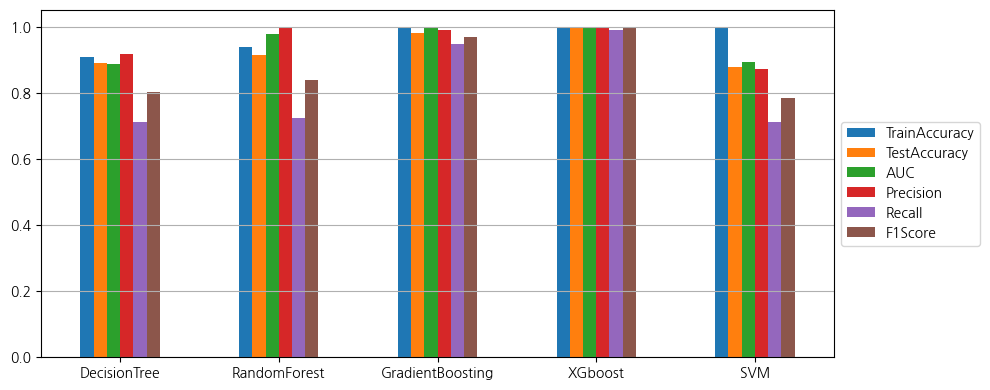

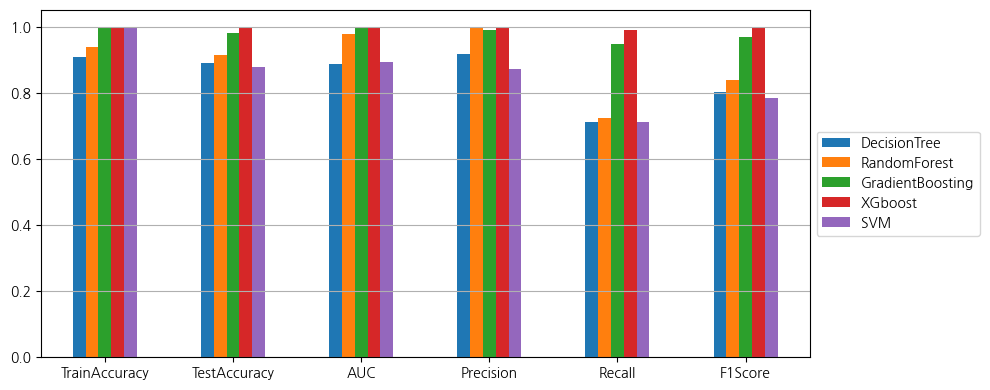

In [23]:
# 1. 데이터 불러오기
# (df_raw, pd, StandardScaler, train_test_split, DecisionTreeClassifier, 
#  RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, SVC,
#  confusion_matrix, classification_report, roc_curve, auc, 
#  precision_score, recall_score, f1_score, plt 등이 사전에 import 되었다고 가정합니다.)

df_model_est = df_raw.copy()

# 2. 목표변수 / 설명변수 분리
df_y_est = df_model_est["scale"]
df_x_est = df_model_est.drop("scale", axis = 1)
df_y_est = df_y_est.map({'불량': 1, '양품': 0})

# 3. 범주형 설명변수 선택 dummy 처리 / 연속형 설명변수 선택 처리
df_x_est_char = df_x_est.select_dtypes(include = "object")
# [수정 1] 변수명을 '더미만 있는' DataFrame으로 명확하게 변경
df_dummies_only = pd.get_dummies(df_x_est_char) 

df_x_est_num = df_x_est.select_dtypes(exclude = "object") 
v_feature_names = df_x_est_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_est_scaled = scaler.fit_transform(df_x_est_num)
df_x_est_scaled = pd.DataFrame(df_x_est_scaled, columns=v_feature_names)

# 4. 3번에서 처리한 설명변수 데이터 결합

# <--- [수정 2] join을 위해 df_x_est_num의 인덱스를 리셋해주는 것이 좋습니다. (원본 데이터에 따라 필요 없을 수도 있음)
# df_x_est_num.reset_index(drop=True, inplace=True) 
# df_x_est_dummy.reset_index(drop=True, inplace=True)
# df_x_est_scaled.reset_index(drop=True, inplace=True)
# df_x_est_char.reset_index(drop=True, inplace=True)

# [수정 2] 주석에 맞게 변수명 변경 (DT/RF/GB용)
df_x_est_raw_dummy = df_x_est_num.join(df_dummies_only) # 원래 연속형 + dummy된 범주형
# (기존 코드: df_x_est_dummy = df_x_est_num.join(df_x_est_dummy))

df_x_est_scale_dummy = df_x_est_scaled.join(df_dummies_only) # scale된 연속형+ dummy된 범주형

df_x_est_scale_raw = df_x_est_scaled.join(df_x_est_char) # scale된 연속형 + 원래 범주형

# 5. train / test 데이터 분할

df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_est_raw_dummy, df_y_est
                                                                 , test_size = 0.3, random_state = 1234)

df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_est_scale_dummy, df_y_est
                                                                 , test_size = 0.3, random_state = 1234)

df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_est_scale_raw, df_y_est
                                                                   , test_size = 0.3, random_state = 1234)

# ===========================================6. 평가 저장=====================================

model = ["DecisionTree", "RandomForest", "GradientBoosting", "XGboost", "SVM"] # <--- [수정 5] 콤마 추가
train_accuracy = []; test_accuracy = [] # 정확도 저장
model_auc = [] # auc score 저장
model_precision = []; model_recall = [] # Precision, Recall score 저장
model_f1_score = [] # f1 score 저장


# 의사결정나무의 성능 
dt_final = DecisionTreeClassifier(max_depth=6, min_samples_split=13, min_samples_leaf=35, random_state=1234)
dt_final.fit(df_train_x_rd, df_train_y) 

train_accuracy.append(dt_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(dt_final.score(df_test_x_rd, df_test_y))

y_prob_1 = dt_final.predict_proba(df_test_x_rd)[:, 1]
y_pred = dt_final.predict(df_test_x_rd)

print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc)

model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))


# RandomForest 저장
rf_final = RandomForestClassifier(min_samples_leaf=10, max_depth=11, n_estimators=100, min_samples_split = 20, random_state=1234)
rf_final.fit(df_train_x_rd, df_train_y)

train_accuracy.append(rf_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(rf_final.score(df_test_x_rd, df_test_y))

y_prob_1 = rf_final.predict_proba(df_test_x_rd)[:, 1]
y_pred = rf_final.predict(df_test_x_rd)

print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc)

model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))


# GradientBoosting 저장
gb_final = GradientBoostingClassifier(min_samples_leaf=21, max_depth=10, n_estimators=300,
                                      learning_rate=0.1, random_state=1234)
gb_final.fit(df_train_x_rd, df_train_y)

train_accuracy.append(gb_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(gb_final.score(df_test_x_rd, df_test_y))

y_prob_1 = gb_final.predict_proba(df_test_x_rd)[:, 1]
y_pred = gb_final.predict(df_test_x_rd)

print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)),"\n")
print(classification_report(df_test_y, y_pred, digits=3))

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc)

model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))

# XGboost 저장
xg_final = XGBClassifier(max_depth=6, n_estimators=50, learning_rate=0.1, random_state=1234)
xg_final.fit(df_train_x_rd, df_train_y)

train_accuracy.append(xg_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(xg_final.score(df_test_x_rd, df_test_y))

y_prob_1 = xg_final.predict_proba(df_test_x_rd)[:, 1]
y_pred = xg_final.predict(df_test_x_rd)

print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)),"\n")
print(classification_report(df_test_y, y_pred, digits=3))

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc) 

model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred)) 
model_f1_score.append(f1_score(df_test_y, y_pred)) 


# SVM 저장
svc_final = SVC(gamma=0.1, C=10, random_state=1234, probability=True) 
svc_final.fit(df_train_x_sd, df_train_y) 

# 평가
y_pred = svc_final.predict(df_test_x_sd)

train_accuracy.append(svc_final.score(df_train_x_sd, df_train_y))
test_accuracy.append(svc_final.score(df_test_x_sd, df_test_y))

y_prob_1 = svc_final.predict_proba(df_test_x_sd)[:, 1]
y_pred = svc_final.predict(df_test_x_sd)

print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)),"\n")
print(classification_report(df_test_y, y_pred, digits=3))

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc) 

model_precision.append(precision_score(df_test_y, y_pred)) 
model_recall.append(recall_score(df_test_y, y_pred)) 
model_f1_score.append(f1_score(df_test_y, y_pred)) 
# ============================================================================================

# 7. 모델별 평가 결과 비교

ax1 = df_eval.plot.bar(rot = 0, figsize=(10,4))
plt.grid(axis = "y")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout() 

plt.show()

ax2 = df_eval.T.plot.bar(rot = 0, figsize=(10,4))
plt.grid(axis = "y")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# 7. Scale - Zero Model MADE BY POSCO 31기 A3

제거 전 전체 행 갯수: 722
제거 후 남은 행 갯수: 722
총 0 개의 행이 제거되었습니다.


,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,rolling_hour,fur_pre_time,heat_soak_diff,pt_area,pt_vol
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.00000,722.000000,722.000000,722.000000,7.220000e+02,7.220000e+02
mean,27.465374,2913.157895,36429.639889,1155.954294,86.063712,1148.562327,73.847645,240.468144,919.912300,8.66205,11.531856,80.556787,7.391967,1.075223e+08,2.121740e+09
std,19.485605,485.468446,15103.760667,22.630405,27.002519,18.458399,21.800420,40.346759,55.640193,1.69176,7.056319,14.922926,13.654447,4.877885e+07,3.681376e+08
min,12.000000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,40.000000,165.000000,723.000000,6.00000,0.000000,55.000000,-39.000000,1.764000e+07,9.936000e+08
25%,14.000000,2600.000000,22550.000000,1137.000000,66.000000,1130.000000,58.000000,208.250000,878.000000,8.00000,5.000000,67.000000,0.000000,5.587000e+07,1.852012e+09
50%,18.000000,2900.000000,41000.000000,1158.000000,74.000000,1151.000000,68.000000,232.000000,932.000000,10.00000,12.000000,81.000000,8.000000,1.231300e+08,2.037910e+09
75%,38.000000,3200.000000,50600.000000,1174.000000,105.000000,1164.000000,85.000000,266.750000,962.000000,10.00000,18.000000,94.000000,14.750000,1.463300e+08,2.373540e+09
max,90.000000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,144.000000,362.000000,1000.000000,10.00000,23.000000,106.000000,56.000000,2.184400e+08,3.058160e+09


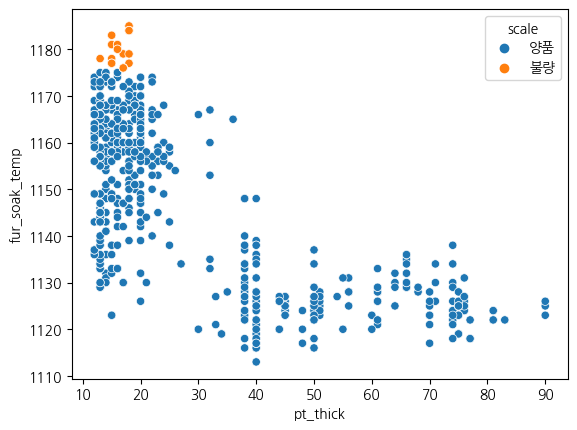

In [27]:
descaling_list = [5, 7, 9]

condition_to_remove = (
    (df_raw['rolling_temp'] > 1000) | 
    (df_raw['hsb'] == '미적용') |
    (df_raw['descaling_count'].isin(descaling_list))
)

df_cleaned = df_raw[~condition_to_remove].copy()

df_raw = df_cleaned

print(f"제거 전 전체 행 갯수: {len(df_raw)}")
print(f"제거 후 남은 행 갯수: {len(df_cleaned)}")
print(f"총 {len(df_raw) - len(df_cleaned)} 개의 행이 제거되었습니다.")

sns.scatterplot(x = 'pt_thick' , y = 'fur_soak_temp' ,hue = 'scale', color = 'scale', data = df_raw)

df_raw.describe()

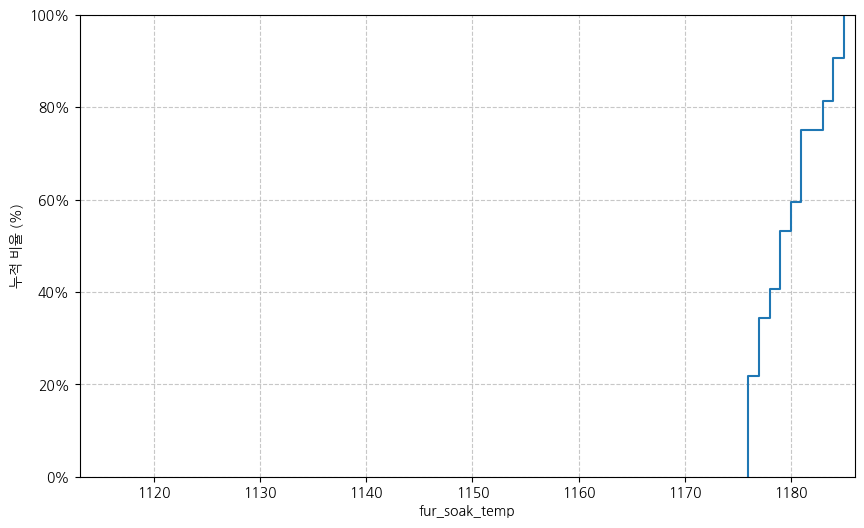

In [31]:
original_count = len(df_raw) 

# 제거하는 변수들
descaling_list = [5, 7, 9]
condition_to_remove = (
    (df_raw['rolling_temp'] > 1000) | 
    (df_raw['hsb'] == '미적용') |
    (df_raw['descaling_count'].isin(descaling_list))
)
df_cleaned = df_raw[~condition_to_remove].copy()

df_raw = df_cleaned
cleaned_count = len(df_raw)

df_faulty = df_raw[df_raw['scale'] == '불량'].copy()
plt.figure(figsize=(10, 6))
ax = sns.ecdfplot(data=df_faulty, x='fur_soak_temp', stat="proportion")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.xlim(1113, 1186) #descirbe 함수를 이용하여 min, max 값을 확인 하였음.
plt.xlabel('fur_soak_temp')
plt.ylabel("누적 비율 (%)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()